In [8]:
import os
from pydub import AudioSegment
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 将 m4a 格式转换为 wav 格式
def formatConvert(audio_path, audio_format):
    audio_name = os.path.splitext(audio_path)[0]
    audio = AudioSegment.from_file(audio_path, format=audio_format)
    audio.export(audio_name + ".wav", format="wav")

In [10]:
# 计算单帧信号的过零率
def zero_crossing_rate(frame):
    signs = np.sign(frame)
    diffs = np.abs(signs[1:] - signs[:-1]) / 2
    zcr = np.sum(diffs)
    return zcr / len(frame)

# 计算短时过零率
# y: 信号
# win: 窗口大小（帧长）
# step: 步长
def short_time_zcr(y, win, step):
    zcrs = []
    for i in range(0, len(y) - win + 1, step):
        frame = y[i:i + win]
        zcr = zero_crossing_rate(frame)
        zcrs.append(zcr)
    return np.array(zcrs)

def visualize_zcr(y, sr, win, step):
    zcrs = short_time_zcr(y, win, step)
    time = np.arange(len(zcrs)) * step / sr
    plt.figure(figsize=(10, 4))
    plt.plot(time, zcrs)
    plt.title('Short-Time Zero Crossing Rate')
    plt.xlabel('Time (s)')
    plt.ylabel('ZCR')
    plt.grid()
    plt.show()

In [11]:
# 计算短时能量
# y: 信号
# win: 窗口大小（帧长）
# step: 步长
def short_time_energy(y, win, step):
    energy = []
    for i in range(0, len(y) - win + 1, step):
        frame = y[i:i + win]
        energy.append(np.sum(frame ** 2))  # 平方和计算能量
    return np.array(energy)

def visualize_energy(y, sr, win, step):
    energy = short_time_energy(y, win, step)
    time = np.arange(len(energy)) * step / sr
    plt.figure(figsize=(10, 4))
    plt.plot(time, energy)
    plt.title('Short-Time Energy')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')
    plt.grid()
    plt.show()

In [ ]:
# 基于双门限法的语音端点检测 (voice activity detection)
# y: 输入音频信号
# sr: 采样率
# win: 帧长
# step: 帧移(ms)
# energy_ratio: 能量阈值（相对于最大能量的比例）
# zcr_thresh: 过零率阈值（绝对阈值）
# silence_duration: 静音持续时间（秒）
# 语音段起止索引列表 [(start1, end1), (start2, end2), ...]

def vad(y, sr, win, step, energy_ratio=0.2, zcr_thresh=0.15, silence_duration=0.2):
    # 计算短时能量和过零率
    energy = short_time_energy(y, win, step)
    zcrs = short_time_zcr(y, win, step)

    # 正则化能量到[0, 1]
    if np.max(energy) > 0:
        energy = energy / np.max(energy)

    # 设置能量阈值
    high_thresh = energy_ratio
    low_thresh = energy_ratio * 0.5

    # 计算静音持续需要的帧数
    silence_frames = int(silence_duration * sr / step)

    segments = []       # 语音段列表
    inSpeech = False    # 是否在语音段中
    start = 0           # 语音段开始索引
    silenceCount = 0   # 静音帧计数

    # 遍历每一帧
    for i in range(len(energy)):
        if not inSpeech:
            # 使用高能量阈值和过零率来检测语音开始
            if energy[i] > high_thresh:
                inSpeech = True
                silenceCount = 0
                # 往回看，使用低能量阈值和过零率来检测语音开始
                for j in range(i-1, -1, -1):
                    if energy[j] < low_thresh and zcrs[j] < zcr_thresh:
                        start = j + 1
                        break
                else:
                    start = i
        else:
            # 使用低能量阈值和过零率来检测静音帧
            if energy[i] < low_thresh and zcrs[i] < zcr_thresh:
                silenceCount += 1
                # 只有当静音持续足够长时间时，才认为语音结束
                if silence_count >= silence_frames:
                    inSpeech = False
                    # 结束点是静音开始的地方
                    end = i - silence_count + 1
                    segments.append((start * step, end * step))
                    silence_count = 0
            else:
                # 重置静音计数
                silence_count = 0

    # 处理语音段到达音频末尾的情况
    if inSpeech:
        segments.append((start * step, len(energy) * step))

    return segments

In [ ]:
formatConvert("audio/shop.m4a", "m4a")
y, _ = librosa.load("audio/shop.wav", sr=8000)

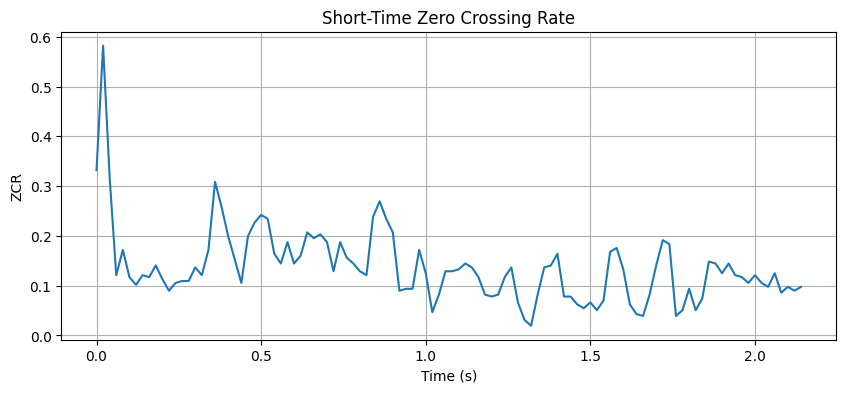

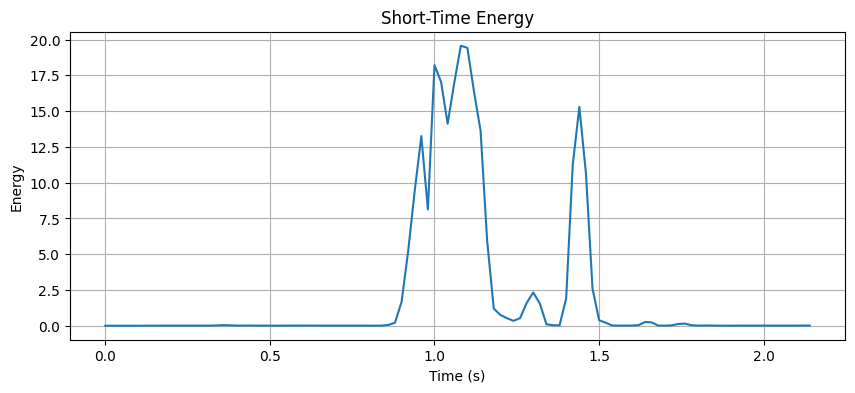

Detected segments:
Start: 6720.00 ms, End: 17280.00 ms


In [ ]:
zrcs = short_time_zcr(y, win=256, step=160)
visualize_zcr(y, 8000, win=256, step=160)

energy = short_time_energy(y, win=256, step=160)
visualize_energy(y, 8000, win=256, step=160)

segments = vad(y, sr=8000, win=256, step=160, energy_ratio=0.2, zcr_thresh=0.15, silence_duration=0.2)
print("Detected segments:")
for start, end in segments:
    print(f"Start: {start:.2f} ms, End: {end:.2f} ms")